   <h1 align="center">3. Segmentation of brain MRI images using SimpleITK</h1>

# Installation

### About SimpleITK

* <b>Simple ITK</b> is a simplified wrapper build on top of Insight Segmentation and Registration Toolkit https://itk.org/Wiki/SimpleITK/GettingStarted/
> <b>ITK</b> is an open-source software toolkit for performing registration and segmentation (https://itk.org/).
* </b>Advantage of SimpleITK</b>: no build required.

### Installation
* using ```pip``` program: ```pip install SimpleITK ```
* using Anaconda Distribution:
  - create a virtual environment: ```conda create --name sitkpy```
  - download SimpleITK: ```conda install -c https://conda.anaconda.org/simpleitk SimpleITK```
  - activate it: ```source activate sitkpy```

### Verify the installation

In [1]:
import SimpleITK as sitk
print(sitk.Version())

SimpleITK Version: 1.0.0 (ITK 4.11)
Compiled: Apr  7 2017 13:57:13



### Import other libraries

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, FloatSlider

from __future__ import print_function

# Download data to work on
%run update_path_to_download_script
from downloaddata import fetch_data as fdata
from myshow import myshow, myshow3d

### Visualize the data

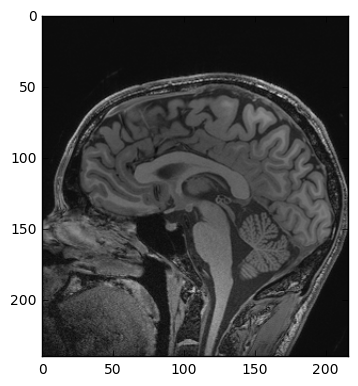

In [3]:
img_T1 = sitk.ReadImage(fdata("nac-hncma-atlas2013-Slicer4Version/Data/A1_grayT1.nrrd"))
img_T2 = sitk.ReadImage(fdata("nac-hncma-atlas2013-Slicer4Version/Data/A1_grayT2.nrrd"))

# To visualize the labels image in RGB with needs a image with 0-255 range
img_T1_255 = sitk.Cast(sitk.RescaleIntensity(img_T1), sitk.sitkUInt8)
img_T2_255 = sitk.Cast(sitk.RescaleIntensity(img_T2), sitk.sitkUInt8)

myshow3d(img_T1)

# Thresholding

### Basic Thresholding

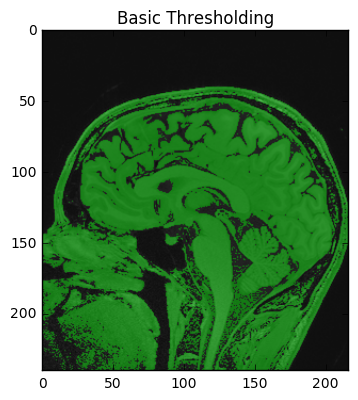

In [4]:
seg = img_T1>200
img_thresholding = sitk.LabelOverlay(img_T1_255, seg)
myshow(img_thresholding, "Basic Thresholding")

### Otsu Thresholding

* examples of histogram based thresholding segmentation methods available in SimpleITK: Huang, MaximumEntropy, Triangle, Otsu.
* automatic computation of the threshold based on the histogram of the image

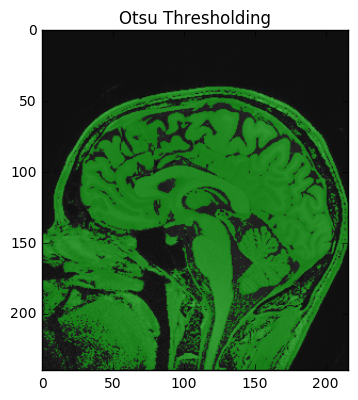

227.5505828857422


In [5]:
otsu_filter = sitk.OtsuThresholdImageFilter()
otsu_filter.SetInsideValue(0)
otsu_filter.SetOutsideValue(1)
seg = otsu_filter.Execute(img_T1)
seg_Otsu = sitk.LabelOverlay(img_T1_255, seg)
myshow(seg_Otsu, "Otsu Thresholding")

print(otsu_filter.GetThreshold() )

### Region Growing Segmentation

* The first step of improvement upon the naive thresholding is a class of algorithms called region growing.
* <b>region growing</b> - starts from a seed region (one or more pixels) to be considered inside the region to be segmented. The pixels neighboring this region are evaluated to determine if they should be part of the region.
* vary depending on the criteria used to decided weather a pixel should be included in the region, or not, the connectivity type to determine the neighbours, and the strategy to visit neighboring pixels.
* SimpleITK included several implementations of the region growing:
<ul>
  <li><b>ConnectedThreshold</b></li>
  <li><b>ConfidenceConnected</b></li>
  <li>VectorConfidenceConnected</li>
  <li>NeighborhoodConnected</li>
</ul>

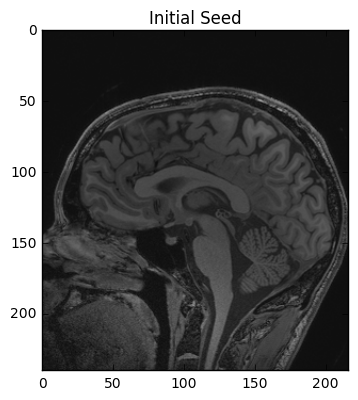

In [6]:
seed = (132,142,96)
seg = sitk.Image(img_T1.GetSize(), sitk.sitkUInt8)
seg.CopyInformation(img_T1)
seg[seed] = 1
seg = sitk.BinaryDilate(seg, 3)
img_seed = sitk.LabelOverlay(img_T1_255,seg)
myshow(img_seed, "Initial Seed")

#### Connected Threshold

* It includes the pixels in a region growing by evaluating intensity value inside a specific interval

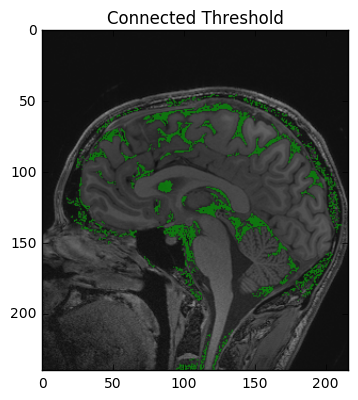

In [7]:
seg = sitk.ConnectedThreshold(img_T1, seedList=[seed], lower=100, upper=190)
img_conn_thre = sitk.LabelOverlay(img_T1_255, seg)
myshow(img_conn_thre, "Connected Threshold")

* Try to modify upper and lower thresholds

- Improving upon this is the ConfidenceConnected filter, which uses the initial seed or current segmentation to estimate the threshold range.

#### Confidence Connected Filter

* The criterion used by the Confidence Connected Filter is based on simple statistics od the current region.
* First, the algorithm computes the mean and the standard deviation of intensity values for all the pixels currently included in the region.
* A user-provided factor is used to multiply the standard deviation  and define a range around the mean.
* Neighbour pixels whose intensity values fall inside the range are accepted and included in the region.
* When no more neighbor pixels are found that satisfy the criterion, the algorithm is considered to have finished its first iteration.
* At that point, the mean and the standard deviation of the intensity levels are recomputed using all the pixels currently included in the region.
* This mean and standard deviation defines a new intensity range that is used to visit current region neighbors and evaluate wheather their intensity falls inside the range.
* This iterative process is repeated until no more pixels are added or the maximum number of iterations is reached.

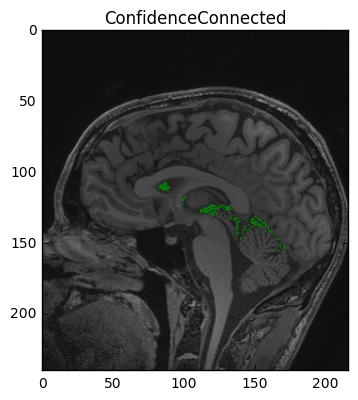

In [8]:
seg = sitk.ConfidenceConnected(img_T1, seedList=[seed],
                                   numberOfIterations=1,
                                   multiplier=2.5,
                                   initialNeighborhoodRadius=1,
                                   replaceValue=1)
img_conf_conn = sitk.LabelOverlay(img_T1_255, seg)
myshow(img_conf_conn, "ConfidenceConnected")

### Fast Marching Segmentation

* Implements a fast marching solution to a simple level set evolution problem (eikonal equation). 
* In this example, the speed term used in the differential equation is provided in the form of an image. 
* The speed image is based on the gradient magnitude and mapped with the bounded reciprocal $1/(1+x)$.

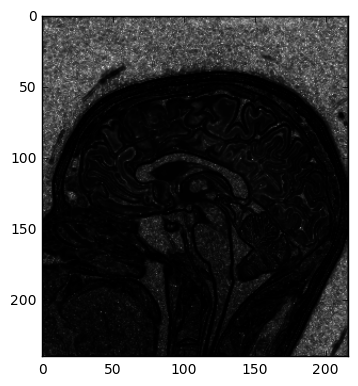

In [9]:
seed = (132,142,96)
feature_img = sitk.GradientMagnitudeRecursiveGaussian(img_T1, sigma=.5)
speed_img = sitk.BoundedReciprocal(feature_img) # This is parameter free unlike the Sigmoid
myshow(speed_img)

* The output of the FastMarchingImageFilter is a <b>time-crossing map</b> that indicates, for each pixel, how much time it would take for the front to arrive at the pixel location.

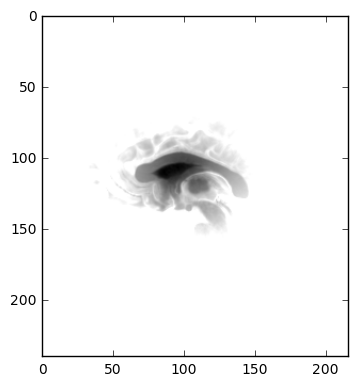

In [10]:
fm_filter = sitk.FastMarchingBaseImageFilter()
fm_filter.SetTrialPoints([seed])
fm_filter.SetStoppingValue(1000)
fm_img = fm_filter.Execute(speed_img)
fm_im_threshold = sitk.Threshold(fm_img,
                    lower=0.0,
                    upper=fm_filter.GetStoppingValue(),
                    outsideValue=fm_filter.GetStoppingValue()+1)
myshow(fm_im_threshold)

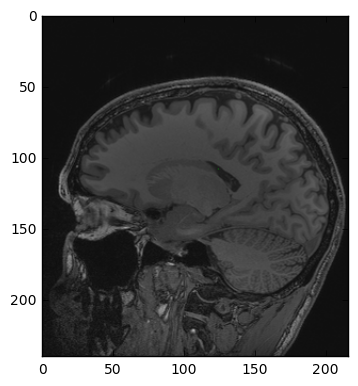

In [11]:
def fm_callback(img, time, z):
    seg = img<time;
    myshow(sitk.LabelOverlay(img_T1_255[:,:,z], seg[:,:,z]))
           
interact( lambda **kwargs: fm_callback(fm_img, **kwargs),
            time=FloatSlider(min=0.05, max=1000.0, step=0.05, value=100.0),
            z=(0,fm_img.GetSize()[2]-1))

### Level Set Segmentation

* Its paradigm - numerical method for tracking the evolution of contours and surfaces
* Instead of manipulating the contour directly, the contour is embedeed as a zero level set of a higher dimensional funtion called the level-set function.

<img src="Data/figures/level_set.png" style="max-width:100%; width: 30%">

* The level-set function is then evolved under the control of a differential equation.
* <b>main advantage</b>: arbitrarily complex shapes can be modeled and topological changes such as merging and splitting are handled implicitly.

* First we create a label image from our seed.

In [12]:
seed = (132,142,96)

seg = sitk.Image(img_T1.GetSize(), sitk.sitkUInt8)
seg.CopyInformation(img_T1)
seg[seed] = 1
seg = sitk.BinaryDilate(seg, 3)

* Use the seed to estimate a reasonable threshold range.
* Level sets can be used for image segmentation by using image-based features such as mean intensity, gradient, and edges in governing the differential equation.

In [13]:
stats = sitk.LabelStatisticsImageFilter()
stats.Execute(img_T1, seg)

factor = 3.5
lower_threshold = stats.GetMean(1)-factor*stats.GetSigma(1)
upper_threshold = stats.GetMean(1)+factor*stats.GetSigma(1)
print(lower_threshold,upper_threshold)

81.25184541308809 175.0084466827569


* In a typical approach, a contour is initialized by user nd is then evolved until it fits the form of an anatomical structure in the image.

In [14]:
init_ls = sitk.SignedMaurerDistanceMap(seg, insideIsPositive=True, useImageSpacing=True)

In [15]:
lsFilter = sitk.ThresholdSegmentationLevelSetImageFilter()
lsFilter.SetLowerThreshold(lower_threshold)
lsFilter.SetUpperThreshold(upper_threshold)
lsFilter.SetMaximumRMSError(0.02)
lsFilter.SetNumberOfIterations(1000)
lsFilter.SetCurvatureScaling(.5)
lsFilter.SetPropagationScaling(1)
lsFilter.ReverseExpansionDirectionOn()
ls = lsFilter.Execute(init_ls, sitk.Cast(img_T1, sitk.sitkFloat32))
print(lsFilter)

itk::simple::ThresholdSegmentationLevelSetImageFilter
  LowerThreshold: 81.2518
  UpperThreshold: 175.008
  MaximumRMSError: 0.02
  PropagationScaling: 1
  CurvatureScaling: 0.5
  NumberOfIterations: 1000
  ReverseExpansionDirection: 1
  ElapsedIterations: 119
  RMSChange: 0.0180966
  Debug: 0
  NumberOfThreads: 4
  Commands: (none)
  ProgressMeasurement: 0.119
  ActiveProcess: (none)



In [16]:
img_level_set = sitk.LabelOverlay(img_T1_255, ls>0)

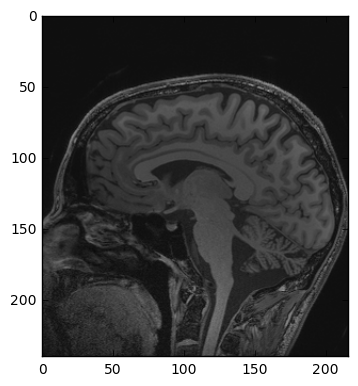

In [17]:
myshow(img_level_set)

### Resources

* ITK Software User Guide: https://itk.org/ItkSoftwareGuide.pdf

* Managing environments in Anaconda: https://conda.io/docs/using/envs.html

* SimpleITK Notebooks: https://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/